<div  >
<img src="https://raw.githubusercontent.com/threeML/astromodels/master/docs/media/transp_logo.png" alt="drawing" width="300" align="right"/>
 


<div  >
<img src="https://raw.githubusercontent.com/threeML/threeML/master/logo/logo_sq.png" alt="drawing" width="300" align="right"/>



# Introduction to basic concepts
    
3ML and astromodels provide a toolbox that allow you to build arbitrailiy complex models and fit them to astrophyical observation. 
    
The three concepts that are key to getting started are:
* building a `model` with astromodels
* creating a `plugin` from data
* performing a `fit`
* manipulating the `AnalysisResults` produced from your fit
    
We will first focus on a simple example with toy data from a generic plugin
 


## Building a plugin

3ML comes with many plugins for various instruments and data classes. It is even possible to construct your own! To beging with, we will be using the `XYLike` plugin which is a simple plugin for so-called point-like data. This is data that is either Poisson or Gaussian distributed where the measured (Y) value is taken exactly at the measurement (X) point. 

In [13]:
from threeML import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook


# Get some example data
from threeML.io.package_data import get_path_of_data_file



Let's get some example data that is included with 3ML

In [2]:
data_path = get_path_of_data_file("datasets/xy_powerlaw.txt")

The `XYLike` plugin can read certain text files. The data we provide is from a power law with Gaussian distribtued errors

[INFO    ] Using Gaussian statistic (equivalent to chi^2) with the provided errors.


<IPython.core.display.Javascript object>


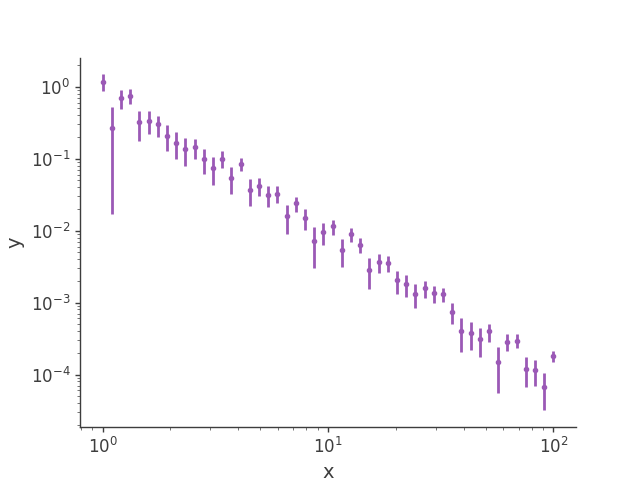

In [6]:
# Create an instance of the XYLike plugin, which allows to analyze simple x,y points
# with error bars
xyl = XYLike.from_text_file(name="xyl", data_path)

# Let's plot it just to see what we have loaded
fig = xyl.plot(x_scale="log", y_scale="log")

In [7]:
xyl.is_poisson

False

In [8]:
xyl.x

array([  1.        ,   1.09854114,   1.20679264,   1.32571137,
         1.45634848,   1.59985872,   1.75751062,   1.93069773,
         2.12095089,   2.32995181,   2.55954792,   2.8117687 ,
         3.0888436 ,   3.39322177,   3.72759372,   4.09491506,
         4.49843267,   4.94171336,   5.42867544,   5.96362332,
         6.55128557,   7.19685673,   7.90604321,   8.68511374,
         9.54095476,  10.48113134,  11.51395399,  12.64855217,
        13.89495494,  15.26417967,  16.76832937,  18.42069969,
        20.23589648,  22.22996483,  24.42053095,  26.82695795,
        29.47051703,  32.37457543,  35.56480306,  39.06939937,
        42.9193426 ,  47.14866363,  51.79474679,  56.89866029,
        62.50551925,  68.6648845 ,  75.43120063,  82.86427729,
        91.0298178 , 100.        ])

Ok, what is a plugin? It is a container for data that connects the data to a model via the plugin's `likelihood`. If we had set a model to the plugin, then we could get the current value of the likelihood given the model's current parameters. But... we do not have a model yet.

## Creating a model

3ML handles models via our sister package [astromodels](https://github.com/threeML/astromodels). In this frame work, a model is a tree that contains sources which contain properties like spectra, polarization, spatial shape, etc. Sources can be point sources (GRBs, AGN, alien warp drive signitures) or extended sources (the galactic place, etc). We will not go into extended sources in this tutorial, but you can check out the documentation to examples with [HAWC]().

For our data/plugin above, we would be interested in the spectral shape of a point source. It looks very much like a power law... so lets try this.

First we will instance a spectral shape



In [10]:
plaw = Powerlaw()
plaw

* description: A simple power-law
  * formula: $ K~\frac{x}{piv}^{index} $
  * parameters:
    * K:
      * value: 1.0
      * desc: Normalization (differential flux at the pivot value)
      * min_value: 1.0e-30
      * max_value: 1000.0
      * unit: ''
      * is_normalization: true
      * delta: 0.1
      * free: true
    * piv:
      * value: 1.0
      * desc: Pivot value
      * min_value: null
      * max_value: null
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: false
    * index:
      * value: -2.01
      * desc: Photon index
      * min_value: -10.0
      * max_value: 10.0
      * unit: ''
      * is_normalization: false
      * delta: 0.20099999999999998
      * free: true

The values of the parameters are accessed as attributes and the function call produces the Y value

In [17]:
plaw.index = 1.
plaw.piv = 10.
# set a lower bound
plaw.K.min_value = 0.

# set bounds simultaneously
plaw.index.bounds = (-3, None)

# free or fix a parameter
plaw.piv.free = True

plaw.piv.fix = True



<IPython.core.display.Javascript object>


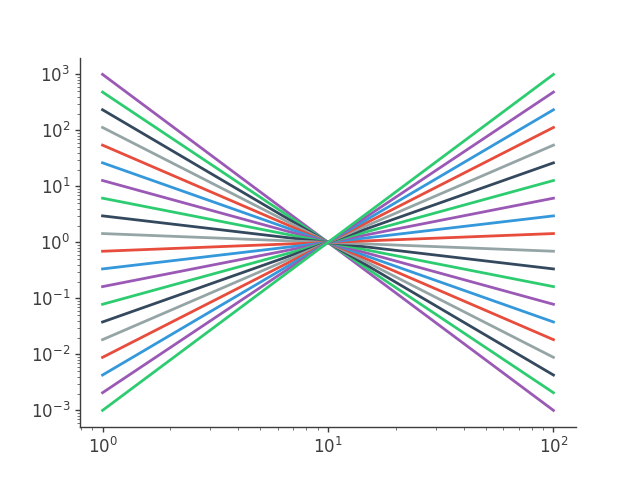

In [18]:
fig, ax = plt.subplots()

x_grid = np.geomspace(1,100,100)

for i in np.linspace(-3,3,20):
    
    plaw.index = i
    
    ax.loglog(x_grid, plaw(x_grid))
    




There are alot of things you can do with functions, however we do not observer functions. We observe sources. So let's assign this spectral shape to a point source. We will have to give it a name and some dummy coordinates.

In [19]:
ps = PointSource("my_source", ra=0, dec=0, spectral_shape=plaw)

In [20]:
ps.free_parameters

OrderedDict([('my_source.spectrum.main.Powerlaw.K',
              Parameter K = 1.0 [1 / (cm2 keV s)]
              (min_value = 0.0, max_value = 1000.0, delta = 0.1, free = True)),
             ('my_source.spectrum.main.Powerlaw.index',
              Parameter index = 3.0 []
              (min_value = -3.0, max_value = None, delta = 0.20099999999999998, free = True))])

Notice the tree structure going from the source to the parameter name? This is the structure of astromodels and how you can access various aspects of a model. It can get really complex.

In [22]:
ps.spectrum.main.Powerlaw.K

Parameter K = 1.0 [1 / (cm2 keV s)]
(min_value = 0.0, max_value = 1000.0, delta = 0.1, free = True)

Now, for this simple example, we have only one source, we will pass this to our model.

In [23]:
model = Model(ps)

In [24]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (2):
--------------------

                                       value min_value max_value  \
my_source.spectrum.main.Powerlaw.K       1.0       0.0    1000.0   
my_source.spectrum.main.Powerlaw.index   3.0      -3.0      None   

                                                  unit  
my_source.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
my_source.spectrum.main.Powerlaw.index                  

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

Now, we are almost ready to fit. But we can go one step further here and get a feeling for how 3ML works. Normally, this is done for you when you perform an analysis, but we can go ahead and assign this model to our plugin:

In [25]:
xyl.set_model(model)

Now we can get our log-likelihood. 3ML knows this is Gaussian data so it uses the proper likelihood... **no you can't change the likelihood to something improper (without some hacking)** because we want your analysis to be correct. 

In [26]:
xyl.get_log_like()

-911783803991970.4

If we change the parameters in our model, the likelihood will change:

In [27]:
plaw.index = -2.

In [28]:
xyl.get_log_like()

-2725918.575595846

In [29]:
model.my_source.spectrum.main.Powerlaw.index=-1

In [30]:
xyl.get_log_like()

-32299102.525830954

Notice that the spectrum instance is linked to the model. Whereever you change the values of the parameters, the plugin will take note an update... remember this for when we perform a fit.... the model will be changed!

## Fitting

Now let's do what we have all come here for... fitting data! There are a plethora of ways to perform fits in 3ML regardless of if you are a die-hard frequentist or frustrated Bayesian. Also remember that all of these procedures are the same regardless of the plugin or type of data you use. This will be important when we switch to X-ray data (or gamma-ray, optical, neutrino, etc.).


### Maximum-Likelihood estimation

First let's do an MLE fit. By default, 3ML comes preloaded with the `minuit` optimizer. Though, you can install others and use them depeneding on your needs. Check out the [documentation]() for examples.

The first thing you need to do in instance a jointlikelihood object. This will automatically set your model to the plugin if you have not done so. Before we do this, we need to create `DataList` which is a container for all the plugins we want to fit (remember we are after multi-messenger analysis). For this case, it is just one plugin:


In [32]:
dl = DataList(xyl)

jl = JointLikelihood(model, dl)

[INFO    ] set the minimizer to minuit


Now we fit!

In [34]:
res = jl.fit()

Best fit values:




WARNING RuntimeWarning: divide by zero encountered in _log10


WARNING RuntimeWarning: divide by zero encountered in _log10


WARNING RuntimeWarning: divide by zero encountered in _log10



,result,unit
parameter,,
my_source.spectrum.main.Powerlaw.K,(0.9 +/- 2.0) x 10^-2,1 / (cm2 keV s)
my_source.spectrum.main.Powerlaw.index,-1.974 +/- 0.033,



Correlation matrix:



1.00,-0.07
-0.07,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,22.762748
xyl,22.762748



Values of statistical measures:



,statistical measures
AIC,49.780816
BIC,53.349543


Great, we have a fit. Now, we need to write a regex parser for the results so that we can save this for later... 

Well, hold on. Let's first try a bayesian fit.

## Bayesian fit

The only difference between a Bayesian fit and an MLE fit is that we need to set priors on our parameters. 3ML comes preloaded with many priors, but you can of course create your own. 



In [36]:
plaw.K.prior = Log_uniform_prior(lower_bound = 1e-3, upper_bound=1e0)

# remember uniform priors are bad! 
plaw.index.prior = Gaussian(mu = -2., sigma=2)

# lets remove the bounds on the index
# so 3ML does not complain

plaw.index.bounds = (None, None)

3ML comes preloaded with emcee as posterior sampler. Hoewever, you can use zeus, multinest, ultranest, etc. All you have to do is set them up according to thier instructions.

In [49]:
bayes = BayesianAnalysis(model, dl)

In [50]:
bayes.set_sampler('emcee')

[INFO    ] sampler set to emcee


In [51]:
bayes.sampler.setup(n_walkers=50, n_warmup=500, n_iterations=500)

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

[INFO    ] Mean acceptance fraction: 0.7110799999999999
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
my_source.spectrum.main.Powerlaw.K,(9.3 +/- 0.4) x 10^-3,1 / (cm2 keV s)
my_source.spectrum.main.Powerlaw.index,-1.974 +/- 0.034,



Values of -log(posterior) at the minimum:



,-log(posterior)
total,-21.434852
xyl,-21.434852



Values of statistical measures:



,statistical measures
AIC,47.125023
BIC,50.693750
DIC,46.983228
PDIC,2.052610


<IPython.core.display.Javascript object>


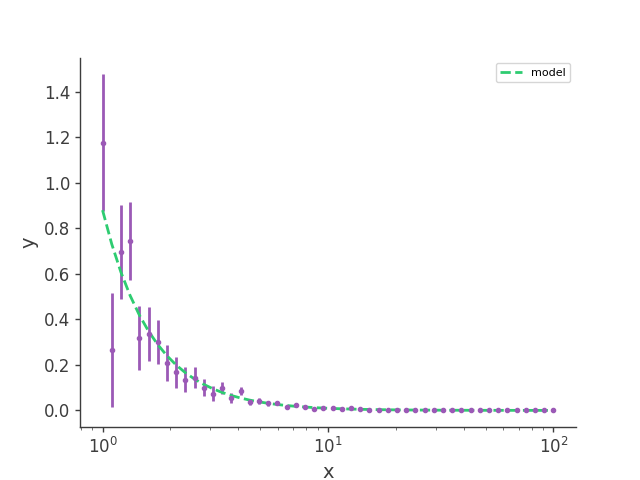

In [52]:
res = bayes.sample()

xyl.plot(x_scale='log');

let's quickly switch to multinest to see if we get the same answer

In [47]:
bayes.set_sampler('multinest')

bayes.sampler.setup(n_live_points=500)

[INFO    ] sampler set to multinest


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
my_source.spectrum.main.Powerlaw.K,(9.3 +/- 0.4) x 10^-3,1 / (cm2 keV s)
my_source.spectrum.main.Powerlaw.index,-1.971 -0.032 +0.033,



Values of -log(posterior) at the minimum:



,-log(posterior)
total,-21.435107
xyl,-21.435107



Values of statistical measures:



,statistical measures
AIC,47.125533
BIC,50.694260
DIC,46.835526
PDIC,1.972438
log(Z),-13.406451


<IPython.core.display.Javascript object>


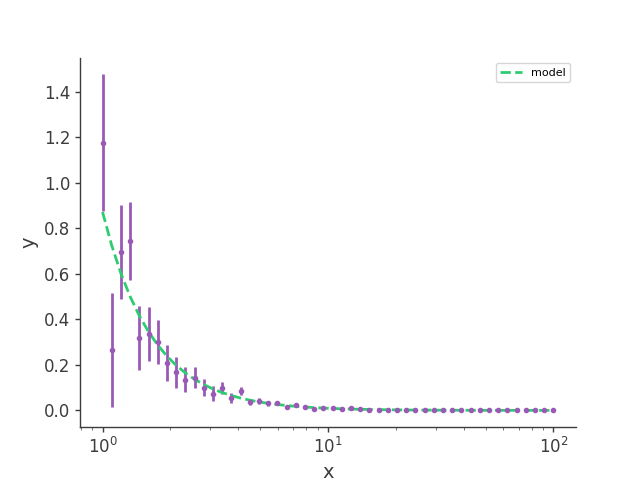

In [48]:
res = bayes.sample()


xyl.plot(x_scale='log');

## AnalysisResults

When we are done with out fit, we want to be able to deal with the results, save them to disk, or even pass them to journal for replication. The `AnalysisResults` object allows us to do this and more. It is important to note that all of these operations are the same for any fit regardless if it is bayesian or MLE.

First, let's extract or results from our fit.
